https://www.kaggle.com/code/marcinrutecki/clustering-methods-comprehensive-study/notebook

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from qvd import qvd_reader

# Import data

In [2]:
file_path = "Y:/Mercanza/ProyectosDVA/CM Proyectos/QVD"
raw_df = qvd_reader.read(file_path + "/vfacturas.qvd")
# raw_df.head()

df_raw = raw_df[["FechaFactura", "Cod_Cli", "TotalFactura"]].copy()
df_raw.head()
df_raw.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42103 entries, 0 to 42102
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   FechaFactura  42103 non-null  object
 1   Cod_Cli       42103 non-null  object
 2   TotalFactura  42100 non-null  object
dtypes: object(3)
memory usage: 986.9+ KB


# Convert data types

In [3]:
type_table = {"FechaFactura": "int32", "Cod_Cli": "string", "TotalFactura": "float32"}

df_raw = df_raw.astype(type_table)
df_raw["FechaFactura"] = pd.to_datetime(
    df_raw["FechaFactura"], unit="D", origin="1899-12-30"  # Excel (Qlik) base date
)

df_raw.info()
df_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42103 entries, 0 to 42102
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   FechaFactura  42103 non-null  datetime64[ns]
 1   Cod_Cli       42103 non-null  string        
 2   TotalFactura  42100 non-null  float32       
dtypes: datetime64[ns](1), float32(1), string(1)
memory usage: 822.4 KB


,FechaFactura,Cod_Cli,TotalFactura
0,2000-01-03,21889,20880.0
1,2000-01-03,22013,222706.0
2,2000-01-03,22052,25881.0
3,2000-01-03,22171,103523.0
4,2000-01-04,22020,156600.0


In [4]:
df_raw.describe(include="all", datetime_is_numeric=True).T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
FechaFactura,42103,NaN,NaN,NaN,2013-03-12 06:26:06.273187328,1992-07-01 00:00:00,2007-10-29 00:00:00,2013-06-27 00:00:00,2019-03-29 00:00:00,2022-11-29 00:00:00,NaN
Cod_Cli,42103,5139,0110,3678,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TotalFactura,42100.0,NaN,NaN,NaN,14117.43457,-2375993.0,109.489998,454.959991,3667.439941,8053648.0,113997.609375


# Aggregate data

In [4]:
df = (
    df_raw.groupby(["Cod_Cli", df_raw["FechaFactura"].dt.year])["TotalFactura"]
    .agg(["sum", "count"])
    .reset_index()
)
df = df.rename(
    columns={
        "FechaFactura": "Year",
        "Cod_Cli": "Code",
        "sum": "Sales",
        "count": "Bills",
    }
)
# df.describe(include='all')
# df.info()
# df.head(10)

# save data for future use
df.to_csv("sales_and_bills.csv", index=False)


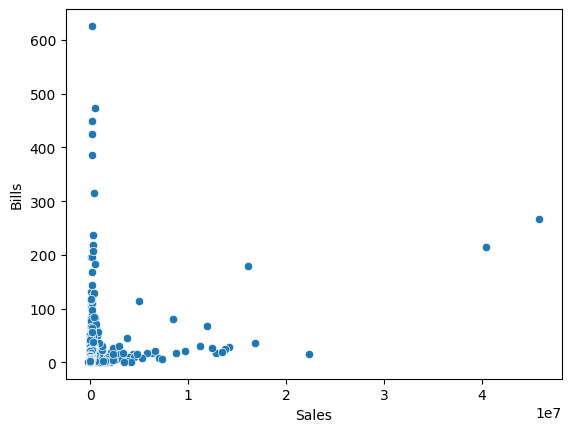

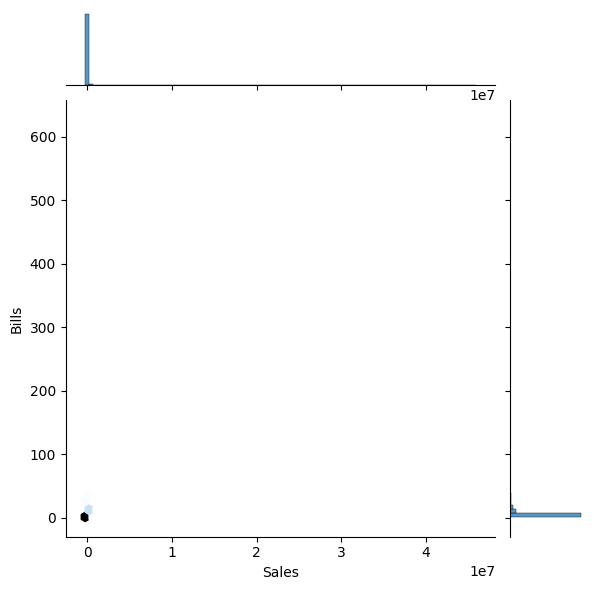

In [5]:
sns.scatterplot(df, x="Sales", y="Bills")
sns.jointplot(
    df, x="Sales", y="Bills", kind="hex", marginal_kws=dict(bins=100, fill=True)
)


[Text(0.5, 0, ''), Text(0, 0.5, '')]

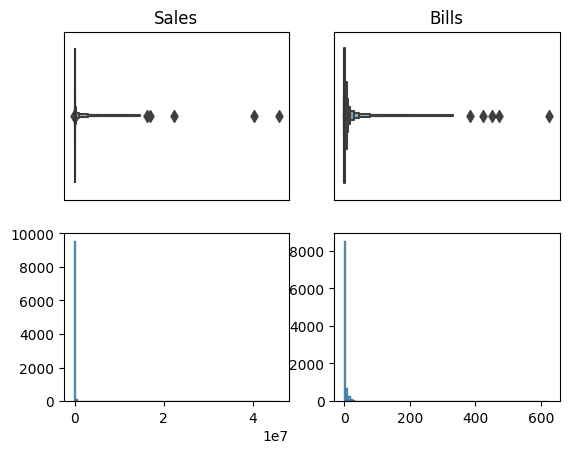

In [6]:
fig, axes = plt.subplots(2, 2)
sns.boxenplot(df["Sales"], ax=axes[0, 0], orient="h")
axes[0, 0].set(title="Sales", xticklabels="", xticks=[], yticks=[])
sns.boxenplot(df["Bills"], ax=axes[0, 1], orient="h")
axes[0, 1].set(title="Bills", xticklabels="", xticks=[], yticks=[])
sns.histplot(df["Sales"], ax=axes[1, 0], bins=100)
axes[1, 0].set(xlabel="", ylabel="")
sns.histplot(df["Bills"], ax=axes[1, 1], bins=100)
axes[1, 1].set(xlabel="", ylabel="")

# Outlier detection

In [7]:
from sklearn.ensemble import IsolationForest

df2 = df.copy()
df2 = df2.drop(["Code", "Year"], axis=1)

In [8]:
model = IsolationForest()
model.fit(df2)

scores = model.decision_function(df2)
anomaly = model.predict(df2)

df2["scores"] = scores
df2["anomaly"] = anomaly

anomaly_index = list(df2.loc[df2["anomaly"] == -1].index)
outliers = len(anomaly_index)
total = len(df2.index)
print(f"Outliers are {outliers:,} of {total:,} ({outliers / total:.1%}).")


Outliers are 893 of 9,760 (9.1%).


<AxesSubplot:xlabel='Sales', ylabel='Bills'>

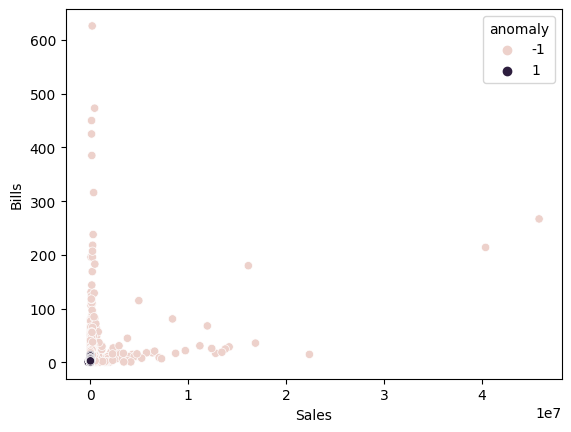

In [9]:
sns.scatterplot(df2, x="Sales", y="Bills", hue="anomaly")


In [10]:
df2 = df2.drop(anomaly_index, axis=0).reset_index(drop=True)

[Text(0.5, 0, ''), Text(0, 0.5, '')]

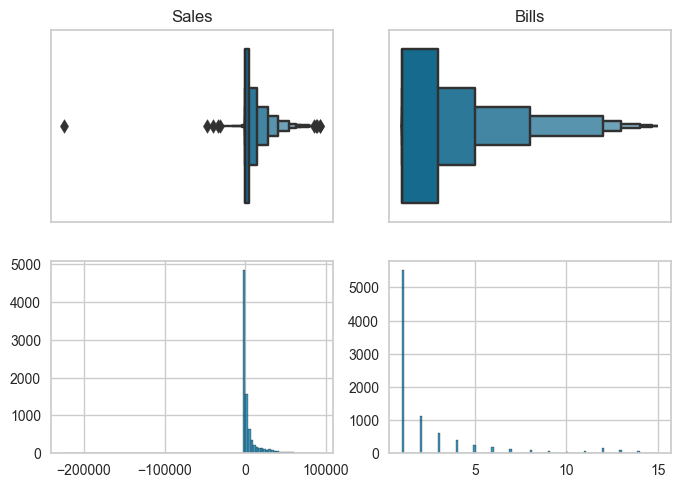

In [51]:
fig, axes = plt.subplots(2, 2)
sns.boxenplot(df2["Sales"], ax=axes[0, 0], orient="h")
axes[0, 0].set(title="Sales", xticklabels="", xticks=[], yticks=[])
sns.boxenplot(df2["Bills"], ax=axes[0, 1], orient="h")
axes[0, 1].set(title="Bills", xticklabels="", xticks=[], yticks=[])
sns.histplot(df2["Sales"], ax=axes[1, 0], bins=100)
axes[1, 0].set(xlabel="", ylabel="")
sns.histplot(df2["Bills"], ax=axes[1, 1], bins=100)
axes[1, 1].set(xlabel="", ylabel="")

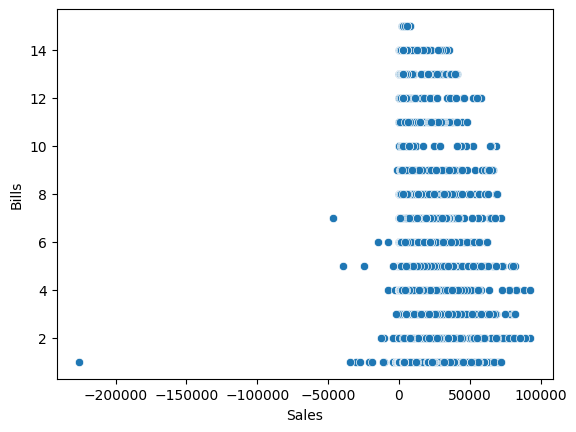

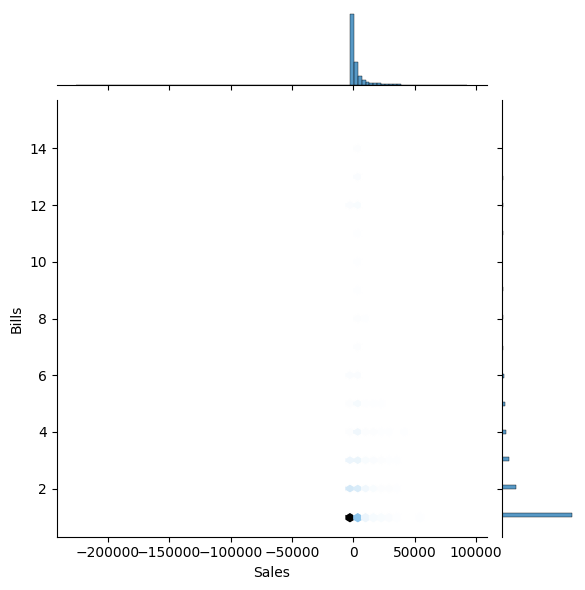

In [12]:
sns.scatterplot(df2, x="Sales", y="Bills")
sns.jointplot(
    df2, x="Sales", y="Bills", kind="hex", marginal_kws=dict(bins=100, fill=True)
)


In [13]:
df2.drop(["scores", "anomaly"], axis=1, inplace=True)


# Scaling data

<AxesSubplot:xlabel='Sales', ylabel='Bills'>

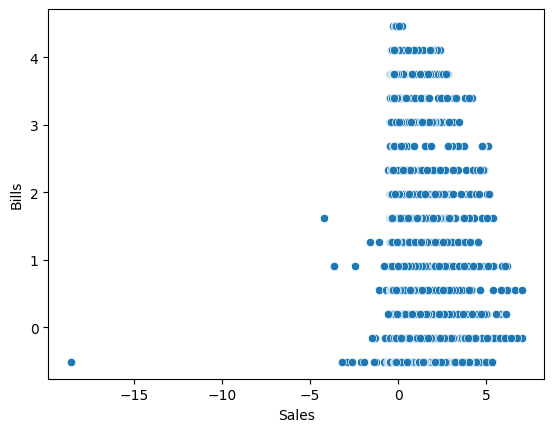

In [14]:
from sklearn.preprocessing import StandardScaler

df3 = pd.DataFrame(StandardScaler().fit_transform(df2), columns=["Sales", "Bills"])
sns.scatterplot(df3, x="Sales", y="Bills")


# Determining The Optimal Number Of Clusters

## Elbow method

In [15]:
from sklearn.cluster import KMeans


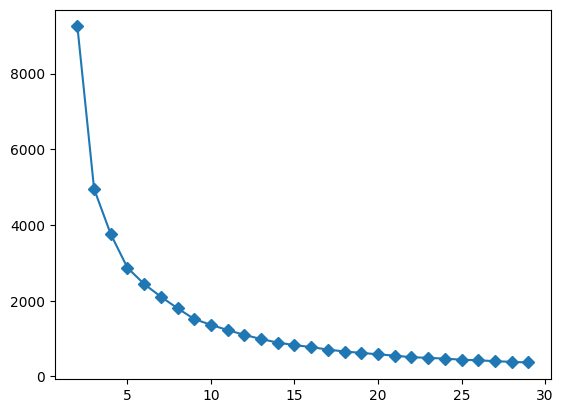

In [16]:
wcss = []
for i in range(2, 30):
    kmeans = KMeans(i, random_state=42)
    kmeans.fit(df3)
    wcss.append(kmeans.inertia_)

plt.plot(range(2, 30), wcss, marker="D")


In [17]:
from yellowbrick.cluster import KElbowVisualizer


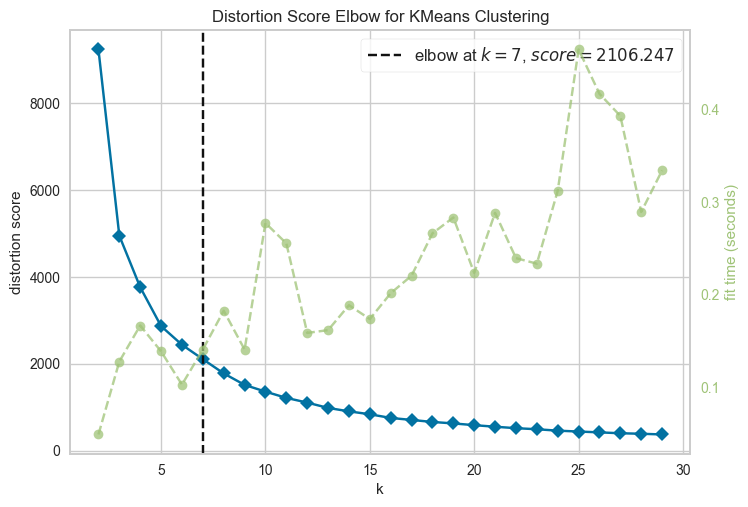

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [18]:
visualizer = KElbowVisualizer(KMeans(), k=(2, 30))
visualizer.fit(df3)
visualizer.show()


## Silhouette Method

In [19]:
from sklearn.metrics import silhouette_score


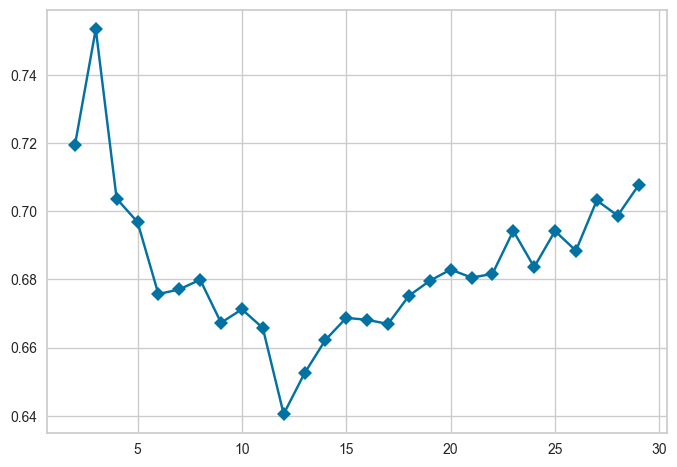

In [20]:
silh = []
for i in range(2, 30):
    kmeans = KMeans(i, random_state=42)
    kmeans.fit_predict(df3)
    score = silhouette_score(df3, kmeans.labels_)
    silh.append(score)
plt.plot(range(2, 30), silh, marker="D")


In [21]:
from yellowbrick.cluster import SilhouetteVisualizer


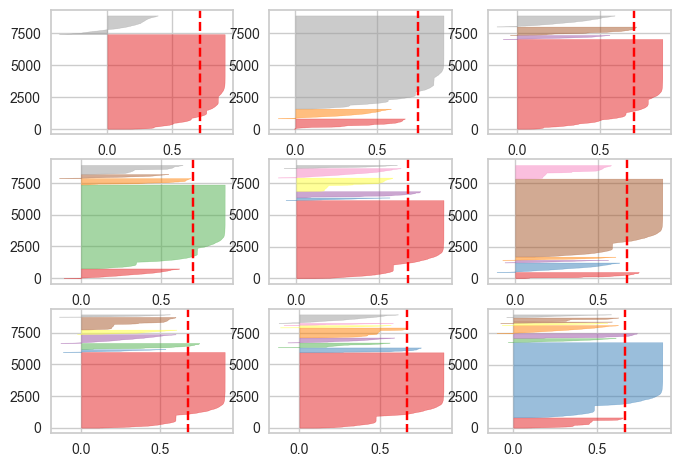

In [22]:
fig, ax = plt.subplots(3, 3)

for i in range(2, 11):
    kmeans = KMeans(i, random_state=42)
    q, mod = divmod(i - 2, 3)
    # print(f"i={i}, q={q} and mod={mod}")
    visualizer = SilhouetteVisualizer(kmeans, ax=ax[q][mod])
    visualizer.fit(df3)


## Dendrogram

In [23]:
from scipy.cluster import hierarchy as sch


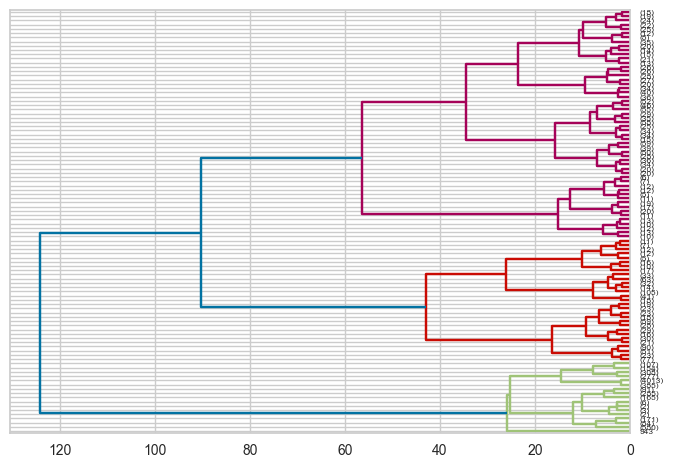

In [24]:
plt.figure()
dendrogram = sch.dendrogram(
    sch.linkage(df3, method="ward"),
    orientation="left",
    leaf_font_size=6,
    truncate_mode="lastp",
    p=100,
    show_contracted=True,
)
plt.show()


# K-Means model

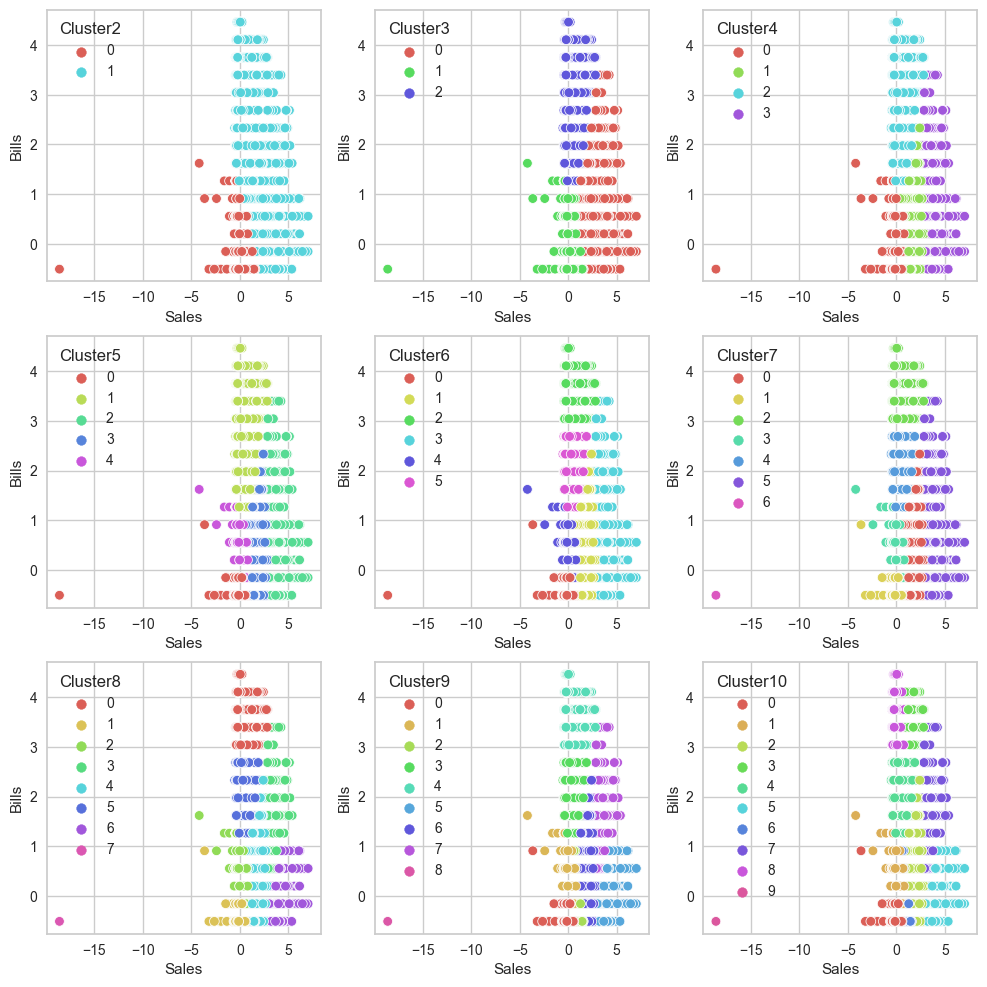

In [25]:
df_kmeans = df3.copy()
fig, ax_kmeans = plt.subplots(3, 3, figsize=(12, 12))
for i in range(2, 11):
    kmeans = KMeans(i, random_state=42)
    y_kmeans = kmeans.fit_predict(df_kmeans)
    q, mod = divmod(i - 2, 3)
    column = "Cluster" + str(i)
    df_kmeans[column] = y_kmeans
    sns.scatterplot(
        df_kmeans,
        x="Sales",
        y="Bills",
        hue=column,
        palette=sns.color_palette("hls", i),
        ax=ax_kmeans[q][mod],
    )

# Hierachical clustering (BIRCH model)

In [27]:
from sklearn.cluster import AgglomerativeClustering as AgClu


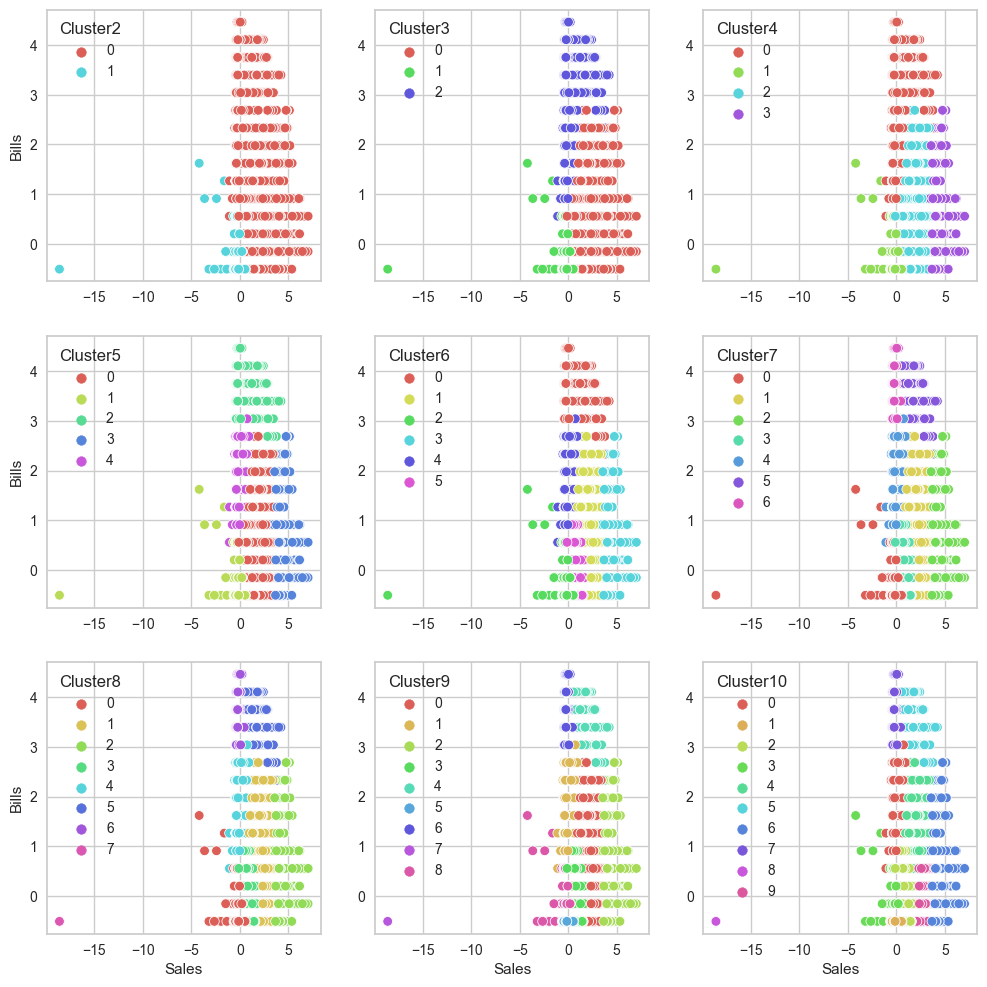

In [49]:
df_birch = df3.copy()
fig, ax_birch = plt.subplots(3, 3, figsize=(12, 12))
for i in range(2, 11):
    agglomerative = AgClu(i)
    y_agglomerative = agglomerative.fit_predict(df_birch)
    q, mod = divmod(i - 2, 3)
    column = "Cluster" + str(i)
    df_birch[column] = y_agglomerative
    sns.scatterplot(
        df_birch,
        x="Sales",
        y="Bills",
        hue=column,
        palette=sns.color_palette("hls", i),
        ax=ax_birch[q][mod],
    )
    ax_birch[q][mod].set(
        xlabel=("Sales" if q == 2 else ""), ylabel=("Bills" if mod == 0 else "")
    )

# DBSCAN clustering algorithm

## Choising initial parameters

In [29]:
from sklearn.neighbors import NearestNeighbors


[Text(0.5, 1.0, 'Epsilon')]

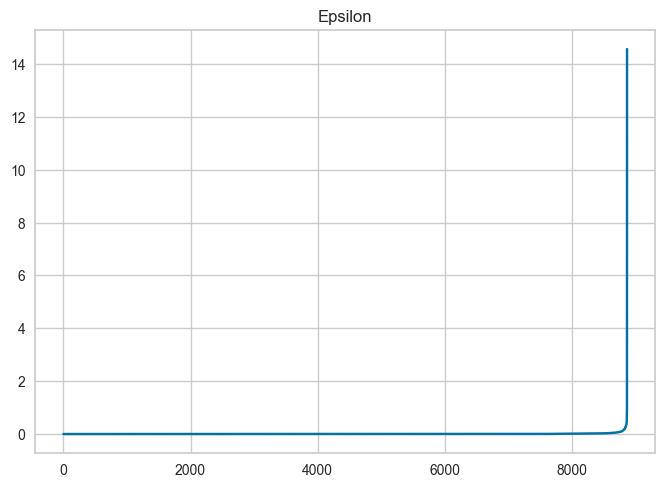

In [57]:
df_dbscan = df3.copy()
nbrs = NearestNeighbors().fit(df_dbscan)
distances, indices = nbrs.kneighbors(df_dbscan)
distances = np.sort(distances, axis=0)
distances = distances[:, 1]
pl = sns.lineplot(distances)
pl.set(title="Epsilon")

In [52]:
from sklearn.cluster import DBSCAN

<AxesSubplot:xlabel='Sales', ylabel='Bills'>

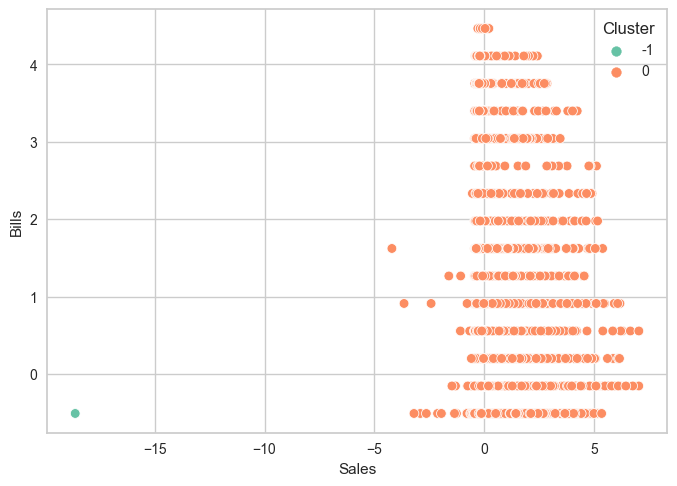

In [61]:
df_dbscan = df3.copy()
dbscan = DBSCAN(eps=14, min_samples=4)
y_dbscan = dbscan.fit_predict(df_dbscan)
df_dbscan['Cluster'] = y_dbscan
sns.scatterplot(df_dbscan, x='Sales', y='Bills', hue='Cluster', palette='Set2')